In [ ]:
# %% 

# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Dropout

##########################################
def normalize_and_sort_by_admission_date(df1, df2):
    """
    Normalize the date column and then sort the provided DataFrames by the given date column.
    
    Parameters:
    df1 (pd.DataFrame): The first DataFrame to normalize and sort.
    df2 (pd.DataFrame): The second DataFrame to normalize and sort.
    
    Returns:
    pd.DataFrame, pd.DataFrame: The normalized and sorted DataFrames.
    """
    # Normalize the date columns in both DataFrames
    df1["Admission_Entry_Date"] = pd.to_datetime(df1["Admission_Entry_Date"]).dt.date
    df2["Admission_Entry_Date"] = pd.to_datetime(df2["Admission_Entry_Date"]).dt.date
    
    # Sort both DataFrames by the normalized date column
    sorted_df1 = df1.sort_values(by="Admission_Entry_Date")
    sorted_df2 = df2.sort_values(by="Admission_Entry_Date")
    
    return sorted_df1, sorted_df2


##########################################
# Load the specific sheets to understand their content
file_path = "F:\\לימודים\\תואר שני\\סמסטר ב\\Data Science 2\\DS2-Final Project\\rehospitalization.xlsx"
units_occupancy_rate = pd.read_excel(file_path, sheet_name='unitsOccupancyRate')
hospitalization1 = pd.read_excel(file_path, sheet_name='hospitalization1')
hospitalization2 = pd.read_excel(file_path, sheet_name='hospitalization2')

In [ ]:
# %% 

# Translate column names to English
column_translation = {
    "תאריך": "Date",
    "מחלקה": "Department",
    "כמות שוהים": "Occupancy",
    "שיעור תפוסה": "Occupancy Rate",
    # Add all other columns that need to be translated
}

units_occupancy_rate.rename(columns=column_translation, inplace=True)
units_occupancy_rate["Date"] = pd.to_datetime(units_occupancy_rate["Date"]).dt.date
units_occupancy_rate.head()

,Date,Department,Occupancy,Occupancy Rate
0,2020-01-01,4,31,0.775
1,2020-01-01,2,30,0.750
2,2020-01-01,5,40,1.000
3,2020-01-01,1,32,0.800
4,2020-01-01,3,37,0.925


In [ ]:
# %%

############################
print("hospitalization1")
display(hospitalization1.head(5))
print("hospitalization2")
display(hospitalization2.head(5))
print("units_occupancy_rate")
display(units_occupancy_rate.head(5))
############################

hospitalization1


,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,סוג קבלה,מהיכן המטופל הגיע,Release_Type,רופא משחרר-קוד,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור
0,62051,1,5207766,2021-09-04 22:21:04.440,2021-09-08 14:43:00,דחוף,מביתו,שוחרר לביתו,6878.0,4,42731,42731
1,951769,2,5605505,2022-02-15 14:39:02.220,2022-02-16 13:37:00,דחוף,אחר,שוחרר לביתו,12615.0,1,Z3601,Z3601
2,863707,2,6755794,2023-05-15 04:21:09.137,2023-05-15 15:59:00,דחוף,מביתו,שוחרר לביתו,12599.0,0,7895,7895
3,884200,3,6964052,2023-07-27 08:16:48.640,2023-07-28 17:34:00,דחוף,ממוסד,שוחרר לביתו,11582.0,1,78609,"4919 , 78609"
4,936226,4,7023187,2023-08-20 19:44:35.410,2023-08-21 15:47:00,דחוף,מביתו,שוחרר לביתו,12359.0,1,78609,"78609 , 81203 , 83100"


hospitalization2


,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,סוג קבלה,מהיכן המטופל הגיע,Release_Type,רופא משחרר,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור,מחלקות מייעצות,ct
0,430047,5,4727327,2021-02-16 17:33:45.570,2021-02-19 12:40:00,5,4745943,2021-02-24 15:03:30.490,2021-02-25 12:38:00,דחוף,מביתו,שוחרר לביתו,11023.0,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",NaN,0
1,447962,4,6084166,2022-08-07 13:27:58.780,2022-08-08 15:15:00,4,6137129,2022-09-01 04:20:51.617,2022-09-02 16:00:00,דחוף,מביתו,שוחרר לביתו,12517.0,1,78060,78060,ריפוי בעיסוק,0
2,214558,5,7164813,2023-10-27 07:34:41.013,2023-10-29 17:18:00,5,7172678,2023-10-30 17:58:09.730,2023-11-01 15:33:00,דחוף,מביתו,שוחרר לביתו,11887.0,2,5119,"5119 , 514",שירות דיאטה,0
3,71277,3,4295329,2020-07-29 17:00:56.863,2020-08-03 14:26:00,3,4354333,2020-08-30 04:25:30.670,2020-09-03 13:45:00,דחוף,מביתו,שוחרר לביתו,10525.0,4,"2859 , 7807","486 , 5990",".שרות לפיזיותרפיה , מערך אורתופדי",0
4,112016,1,5052676,2021-07-03 11:42:24.973,2021-07-05 17:34:00,1,5078317,2021-07-13 01:21:32.077,2021-07-15 11:48:00,דחוף,מביתו,שוחרר לביתו,6890.0,2,7865,7865,"קרדיולוגיה- יעוצים , שירות דיאטה",1


units_occupancy_rate


,Date,Department,Occupancy,Occupancy Rate
0,2020-01-01,4,31,0.775
1,2020-01-01,2,30,0.750
2,2020-01-01,5,40,1.000
3,2020-01-01,1,32,0.800
4,2020-01-01,3,37,0.925


In [ ]:
# %%

# Normalize the dates to be only the date without time
hospitalization2['Admission_Entry_Date'] = pd.to_datetime(hospitalization2['Admission_Entry_Date']).dt.date
hospitalization2['Release_Date'] = pd.to_datetime(hospitalization2['Release_Date']).dt.date
hospitalization2['Admission_Entry_Date2'] = pd.to_datetime(hospitalization2['Admission_Entry_Date2']).dt.date
hospitalization2['Release_Date2'] = pd.to_datetime(hospitalization2['Release_Date2']).dt.date

# Calculate the days between Release_Date and Admission_Entry_Date2
hospitalization2['Days_Between'] = (pd.to_datetime(hospitalization2['Admission_Entry_Date2']) - pd.to_datetime(hospitalization2['Release_Date'])).dt.days

# Categorize the Days_Between into 'Short', 'Medium', 'Long'
hospitalization2['Duration_Category'] = pd.cut(hospitalization2['Days_Between'], bins=[-1, 10, 20, 30], labels=['Short', 'Medium', 'Long'])

In [ ]:
# %%

# Display the updated dataframe with the new category column
hospitalization2.head()

,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,סוג קבלה,מהיכן המטופל הגיע,Release_Type,רופא משחרר,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור,מחלקות מייעצות,ct,Days_Between,Duration_Category
0,430047,5,4727327,2021-02-16,2021-02-19,5,4745943,2021-02-24,2021-02-25,דחוף,מביתו,שוחרר לביתו,11023.0,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",NaN,0,5,Short
1,447962,4,6084166,2022-08-07,2022-08-08,4,6137129,2022-09-01,2022-09-02,דחוף,מביתו,שוחרר לביתו,12517.0,1,78060,78060,ריפוי בעיסוק,0,24,Long
2,214558,5,7164813,2023-10-27,2023-10-29,5,7172678,2023-10-30,2023-11-01,דחוף,מביתו,שוחרר לביתו,11887.0,2,5119,"5119 , 514",שירות דיאטה,0,1,Short
3,71277,3,4295329,2020-07-29,2020-08-03,3,4354333,2020-08-30,2020-09-03,דחוף,מביתו,שוחרר לביתו,10525.0,4,"2859 , 7807","486 , 5990",".שרות לפיזיותרפיה , מערך אורתופדי",0,27,Long
4,112016,1,5052676,2021-07-03,2021-07-05,1,5078317,2021-07-13,2021-07-15,דחוף,מביתו,שוחרר לביתו,6890.0,2,7865,7865,"קרדיולוגיה- יעוצים , שירות דיאטה",1,8,Short


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


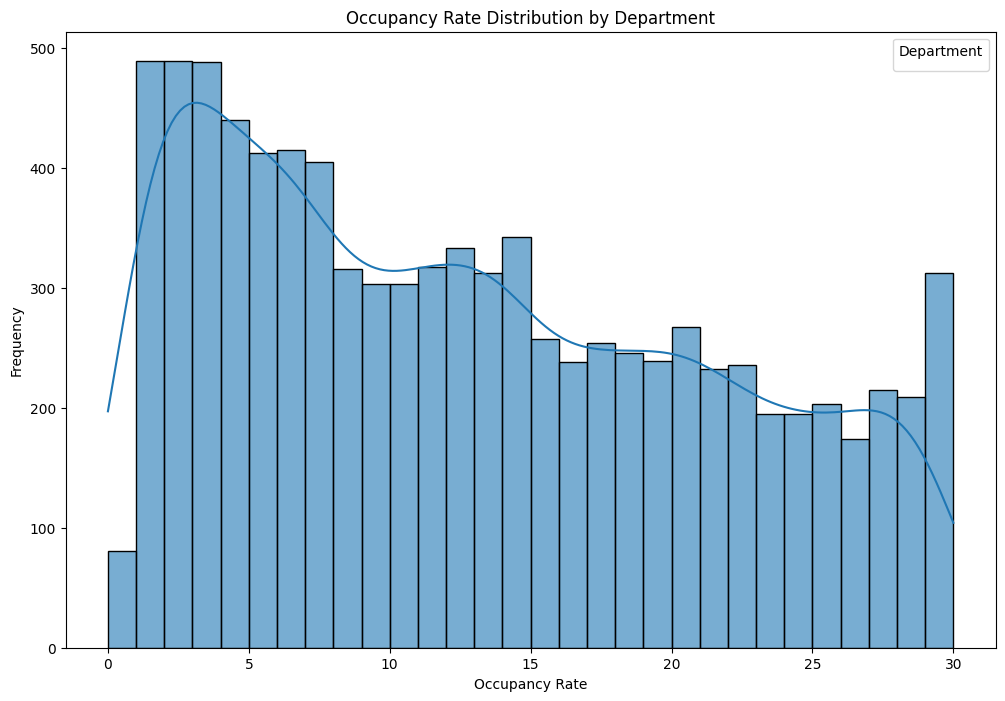

In [ ]:
# %% 

plt.figure(figsize=(12, 8))
sns.histplot(hospitalization2["Days_Between"], kde=True, bins=30, alpha=0.6
    )
plt.title("Occupancy Rate Distribution by Department")
plt.xlabel("Occupancy Rate")
plt.ylabel("Frequency")
plt.legend(title="Department")
plt.show()

In [ ]:
# %%

def get_occupancy_rate(date, department, units_occupancy_rate):
    """
    Retrieve the Occupancy Rate for a given date and department.

    Parameters:
    date (str or pd.Timestamp): The date for which to retrieve the Occupancy Rate.
    department (str or int): The department for which to retrieve the Occupancy Rate.
    units_occupancy_rate (pd.DataFrame): The DataFrame containing occupancy rate data.

    Returns:
    float: The Occupancy Rate for the given date and department, or None if not found.
    """
    # Convert date to datetime if it's not already
    date = pd.to_datetime(date).date()
    
    # Convert department to string and strip any leading/trailing spaces
    department = str(department).strip()

    # Filter the DataFrame for the matching date and department
    result = units_occupancy_rate[(units_occupancy_rate['Date'] == date) & 
                                  (units_occupancy_rate['Department'].astype(str).str.strip() == department)]

    # Return the Occupancy Rate if found, otherwise return None
    if not result.empty:
        return result['Occupancy Rate'].values[0]
    else:
        return None

In [ ]:
# %% 

rate = get_occupancy_rate("2022-01-25", 4 ,units_occupancy_rate)
display(rate)

0.625

In [ ]:
# %%

# Add a new column 'Unit_Occupancy_Rate_ReleaseDate' by applying the get_occupancy_rate function
hospitalization2['Unit_Occupancy_Rate_ReleaseDate'] = hospitalization2.apply(
    lambda row: get_occupancy_rate(row['Release_Date'], row['unitName1'], units_occupancy_rate), axis=1
)

In [ ]:
# %% 

# display the updated DataFrame with the new column
display(hospitalization2[['Release_Date', 'unitName1', 'Unit_Occupancy_Rate_ReleaseDate']].head())

,Release_Date,unitName1,Unit_Occupancy_Rate_ReleaseDate
0,2021-02-19,5,0.800
1,2022-08-08,4,0.675
2,2023-10-29,5,0.850
3,2020-08-03,3,0.975
4,2021-07-05,1,0.850


In [ ]:
# %%

# Check for Null Values
hospitalization2.Unit_Occupancy_Rate_ReleaseDate.isnull().sum()

20

In [ ]:
# %% 

# Identify all rows (indexes) that contain any NaN values
nan_indexes = hospitalization2[hospitalization2['Unit_Occupancy_Rate_ReleaseDate'].isna()].index

# Display the indexes with NaN values
print("Indexes with NaN values:", nan_indexes.tolist())

# Drop the rows with NaN values from the hospitalization2 DataFrame
hospitalization2_cleaned = hospitalization2.drop(index=nan_indexes)

# Display the cleaned DataFrame to verify that the rows were removed
display(hospitalization2_cleaned.head())

Indexes with NaN values: [466, 1275, 2187, 2528, 2774, 3369, 3428, 3448, 4637, 5667, 6147, 6570, 7510, 7601, 7873, 8286, 8537, 8585, 8642, 8700]


,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,סוג קבלה,...,Release_Type,רופא משחרר,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור,מחלקות מייעצות,ct,Days_Between,Duration_Category,Unit_Occupancy_Rate_ReleaseDate
0,430047,5,4727327,2021-02-16,2021-02-19,5,4745943,2021-02-24,2021-02-25,דחוף,...,שוחרר לביתו,11023.0,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",NaN,0,5,Short,0.800
1,447962,4,6084166,2022-08-07,2022-08-08,4,6137129,2022-09-01,2022-09-02,דחוף,...,שוחרר לביתו,12517.0,1,78060,78060,ריפוי בעיסוק,0,24,Long,0.675
2,214558,5,7164813,2023-10-27,2023-10-29,5,7172678,2023-10-30,2023-11-01,דחוף,...,שוחרר לביתו,11887.0,2,5119,"5119 , 514",שירות דיאטה,0,1,Short,0.850
3,71277,3,4295329,2020-07-29,2020-08-03,3,4354333,2020-08-30,2020-09-03,דחוף,...,שוחרר לביתו,10525.0,4,"2859 , 7807","486 , 5990",".שרות לפיזיותרפיה , מערך אורתופדי",0,27,Long,0.975
4,112016,1,5052676,2021-07-03,2021-07-05,1,5078317,2021-07-13,2021-07-15,דחוף,...,שוחרר לביתו,6890.0,2,7865,7865,"קרדיולוגיה- יעוצים , שירות דיאטה",1,8,Short,0.850


In [ ]:
hospitalization2_cleaned

,Patient,unitName1,Admission_Medical_Record,Admission_Entry_Date,Release_Date,unitName2,Admission_Medical_Record2,Admission_Entry_Date2,Release_Date2,סוג קבלה,...,Release_Type,רופא משחרר,ימי אשפוז,אבחנות בקבלה,אבחנות בשחרור,מחלקות מייעצות,ct,Days_Between,Duration_Category,Unit_Occupancy_Rate_ReleaseDate
0,430047,5,4727327,2021-02-16,2021-02-19,5,4745943,2021-02-24,2021-02-25,דחוף,...,שוחרר לביתו,11023.0,1,"5370 , 7872 , 78720","5370 , 7872 , 78720",NaN,0,5,Short,0.800
1,447962,4,6084166,2022-08-07,2022-08-08,4,6137129,2022-09-01,2022-09-02,דחוף,...,שוחרר לביתו,12517.0,1,78060,78060,ריפוי בעיסוק,0,24,Long,0.675
2,214558,5,7164813,2023-10-27,2023-10-29,5,7172678,2023-10-30,2023-11-01,דחוף,...,שוחרר לביתו,11887.0,2,5119,"5119 , 514",שירות דיאטה,0,1,Short,0.850
3,71277,3,4295329,2020-07-29,2020-08-03,3,4354333,2020-08-30,2020-09-03,דחוף,...,שוחרר לביתו,10525.0,4,"2859 , 7807","486 , 5990",".שרות לפיזיותרפיה , מערך אורתופדי",0,27,Long,0.975
4,112016,1,5052676,2021-07-03,2021-07-05,1,5078317,2021-07-13,2021-07-15,דחוף,...,שוחרר לביתו,6890.0,2,7865,7865,"קרדיולוגיה- יעוצים , שירות דיאטה",1,8,Short,0.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8912,211853,3,6039709,2022-07-20,2022-07-24,3,6098330,2022-08-12,2022-08-15,דחוף,...,שוחרר למוסד,10126.0,3,2501,"0389 , 2501 , INT1",".שרות לפיזיותרפיה , שירות דיאטה",1,19,Medium,1.050
8913,315804,1,6951338,2023-07-22,2023-07-23,1,6999513,2023-08-10,2023-08-14,דחוף,...,שוחרר לביתו,6888.0,4,4359,3458,".שרות לפיזיותרפיה , מחלקת נוירולוגיה , מכון E...",0,18,Medium,0.850
8914,191393,2,7052449,2023-09-05,2023-09-06,2,7091821,2023-09-20,2023-09-27,דחוף,...,שוחרר לביתו,1769.0,7,514,"514 , Z37211",NaN,0,14,Medium,0.725
8915,16538,1,3912954,2020-01-19,2020-01-21,1,3987601,2020-02-19,2020-02-24,דחוף,...,שוחרר לביתו,7993.0,5,7872,7872,".שרות לפיזיותרפיה , שירות דיאטה",0,29,Long,0.850
